# Notebook 01 — Prétraitement Audio : Du Signal Brut au Spectrogramme Log-Mel

## Transition Texte → Audio

Dans les chapitres précédents, nous avons vu comment traiter du **texte** :
- **Chapitre 1** : Architecture Transformer, self-attention, multi-head attention
- **Chapitre 2** : Tokenisation BPE, embeddings, préparation des données textuelles

La tokenisation BPE découpe le texte en sous-mots discrets. Pour l'audio, nous avons besoin d'un équivalent : le **spectrogramme Log-Mel** joue le rôle de « tokenisation audio », transformant un signal continu en une représentation structurée exploitable par un réseau de neurones.

| Texte | Audio |
|-------|-------|
| Signal discret (caractères) | Signal continu (waveform) |
| Tokenisation BPE → sous-mots | STFT + Mel → Log-Mel spectrogram |
| Embedding lookup | Feature Encoder (CNN 1D) |

Ce notebook implémente la chaîne complète : **waveform → spectrogramme → Log-Mel**, d'abord **from scratch** (NumPy pur) puis avec **librosa**.

In [7]:
%%capture
!pip install -r ../../../mini-gpt-workshop/requirements.txt

In [8]:
import sys
from pathlib import Path

# Ajouter src/ au path
src_path = str(Path("../../src").resolve())
if src_path not in sys.path:
    sys.path.insert(0, src_path)

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 4)
plt.rcParams['figure.dpi'] = 100

## Cell 2 — Chargement audio et affichage de la waveform

On charge un fichier audio échantillonné à 16 kHz (standard pour l'ASR) et on affiche la forme d'onde brute.

Fréquence d'échantillonnage : 16000 Hz
Nombre d'échantillons : 32000
Durée : 2.00 s
Shape : (32000,)


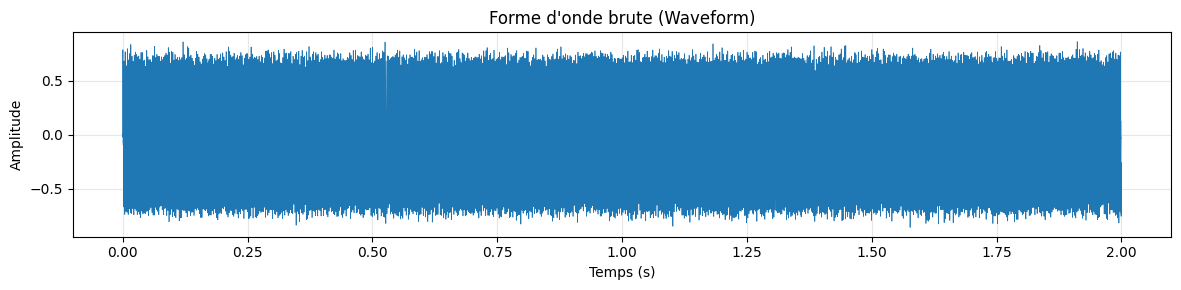

In [9]:
from audio.preprocessing import load_audio

# Charger le fichier audio d'exemple
audio_path = "../../data/raw/sample_audio.wav"
waveform, sr = load_audio(audio_path, target_sr=16000)

print(f"Fréquence d'échantillonnage : {sr} Hz")
print(f"Nombre d'échantillons : {len(waveform)}")
print(f"Durée : {len(waveform) / sr:.2f} s")
print(f"Shape : {waveform.shape}")

# Afficher la waveform
time_axis = np.arange(len(waveform)) / sr
plt.figure(figsize=(12, 3))
plt.plot(time_axis, waveform, linewidth=0.5)
plt.title("Forme d'onde brute (Waveform)")
plt.xlabel("Temps (s)")
plt.ylabel("Amplitude")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [6]:
from IPython.display import Audio

Audio(waveform, rate=sr)

## Cell 3 — IMPLÉMENTATION FROM SCRATCH : Calcul de la STFT

La **Short-Time Fourier Transform (STFT)** décompose le signal en trames temporelles et applique la FFT à chacune.

**Étapes :**
1. Découper le signal en trames de taille `n_fft` avec un pas `hop_length`
2. Appliquer une fenêtre de Hann à chaque trame (réduction des fuites spectrales)
3. Calculer la FFT de chaque trame fenêtrée
4. Prendre le module (magnitude) du résultat complexe

$$X(t, f) = \left| \sum_{n=0}^{N-1} x(n + t \cdot H) \cdot w(n) \cdot e^{-j2\pi f n / N} \right|$$

Shape du spectrogramme : (201, 198)
  → n_freq = n_fft // 2 + 1 = 400 // 2 + 1 = 201
  → n_frames = (num_samples - n_fft) // hop_length + 1 = (32000 - 400) // 160 + 1 = 198
Valeurs finies ? True


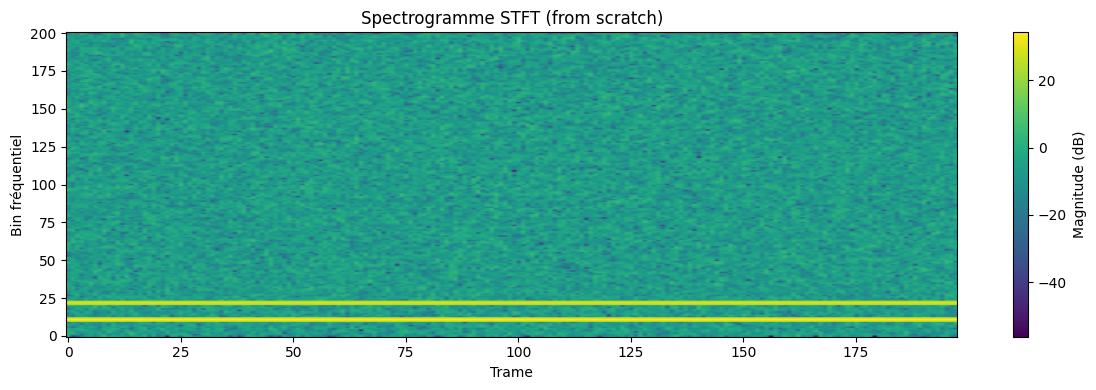

In [10]:
from audio.preprocessing import compute_stft_from_scratch

# Paramètres STFT
n_fft = 400       # Taille de la fenêtre (25 ms à 16 kHz)
hop_length = 160   # Pas de la fenêtre (10 ms à 16 kHz)

# Calcul STFT from scratch
spectrogram_scratch = compute_stft_from_scratch(waveform, n_fft=n_fft, hop_length=hop_length)

print(f"Shape du spectrogramme : {spectrogram_scratch.shape}")
print(f"  → n_freq = n_fft // 2 + 1 = {n_fft} // 2 + 1 = {n_fft // 2 + 1}")
print(f"  → n_frames = (num_samples - n_fft) // hop_length + 1 = ({len(waveform)} - {n_fft}) // {hop_length} + 1 = {spectrogram_scratch.shape[1]}")
print(f"Valeurs finies ? {np.all(np.isfinite(spectrogram_scratch))}")

# Afficher le spectrogramme en dB
plt.figure(figsize=(12, 4))
plt.imshow(
    20 * np.log10(np.maximum(1e-10, spectrogram_scratch)),
    aspect='auto', origin='lower', cmap='viridis'
)
plt.colorbar(label='Magnitude (dB)')
plt.title('Spectrogramme STFT (from scratch)')
plt.xlabel('Trame')
plt.ylabel('Bin fréquentiel')
plt.tight_layout()
plt.show()

## Cell 4 — IMPLÉMENTATION FROM SCRATCH : Filtres Mel triangulaires

L'échelle **Mel** imite la perception humaine des fréquences (non-linéaire : on distingue mieux les basses fréquences).

**Conversion Hz ↔ Mel :**
$$m = 2595 \cdot \log_{10}\left(1 + \frac{f}{700}\right) \qquad f = 700 \cdot \left(10^{m/2595} - 1\right)$$

On construit `n_mels` filtres triangulaires espacés linéairement en échelle Mel, puis on les applique au spectrogramme de puissance.

Shape des filtres Mel : (80, 201)  (n_mels, n_freq)


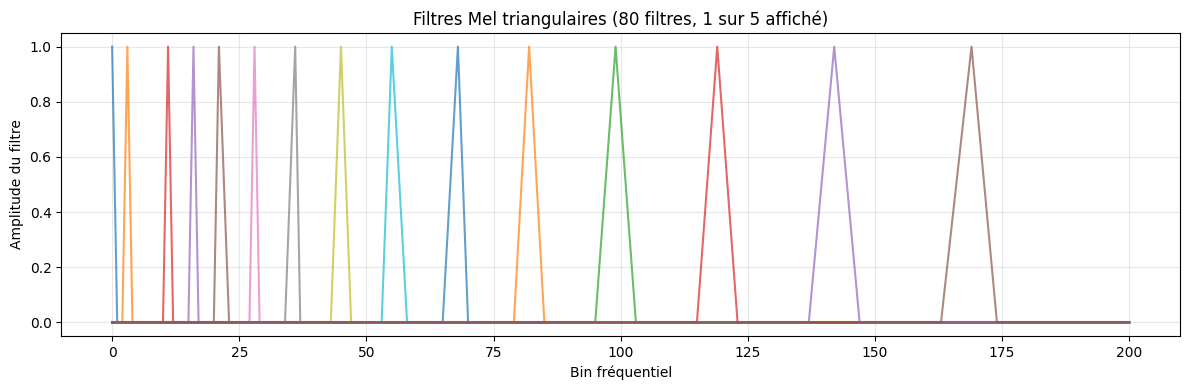

Shape du spectrogramme Mel : (80, 198)  (n_mels, n_frames)


In [11]:
from audio.preprocessing import compute_mel_filterbank_from_scratch

n_mels = 80

# Construire les filtres Mel from scratch
mel_filterbank = compute_mel_filterbank_from_scratch(sr=sr, n_fft=n_fft, n_mels=n_mels)
print(f"Shape des filtres Mel : {mel_filterbank.shape}  (n_mels, n_freq)")

# Visualiser les filtres
plt.figure(figsize=(12, 4))
for i in range(0, n_mels, 5):  # Afficher 1 filtre sur 5
    plt.plot(mel_filterbank[i], alpha=0.7)
plt.title(f'Filtres Mel triangulaires ({n_mels} filtres, 1 sur 5 affiché)')
plt.xlabel('Bin fréquentiel')
plt.ylabel('Amplitude du filtre')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Appliquer les filtres au spectrogramme de puissance
power_spec = spectrogram_scratch ** 2
mel_spec_scratch = mel_filterbank @ power_spec
print(f"Shape du spectrogramme Mel : {mel_spec_scratch.shape}  (n_mels, n_frames)")

## Cell 5 — IMPLÉMENTATION FROM SCRATCH : Log-Mel complet + comparaison librosa

Le pipeline complet from scratch : STFT → |STFT|² → Mel filterbank → log()

On compare ensuite avec la version librosa pour valider notre implémentation.

In [12]:
from audio.preprocessing import compute_log_mel_from_scratch, compute_log_mel

# Log-Mel from scratch
log_mel_scratch = compute_log_mel_from_scratch(
    waveform, sr=sr, n_mels=n_mels, n_fft=n_fft, hop_length=hop_length
)
print(f"Log-Mel from scratch — shape : {log_mel_scratch.shape}")
print(f"  Valeurs finies ? {np.all(np.isfinite(log_mel_scratch))}")
print(f"  Min : {log_mel_scratch.min():.2f}, Max : {log_mel_scratch.max():.2f}")

# Log-Mel via librosa
log_mel_librosa = compute_log_mel(
    waveform, sr=sr, n_mels=n_mels, n_fft=n_fft, hop_length=hop_length
)
print(f"\nLog-Mel librosa — shape : {log_mel_librosa.shape}")
print(f"  Min : {log_mel_librosa.min():.2f}, Max : {log_mel_librosa.max():.2f}")

# Comparaison
# Note : les valeurs ne seront pas identiques car librosa utilise
# un padding et une normalisation légèrement différents, mais les
# shapes et ordres de grandeur doivent correspondre.
print(f"\nComparaison des shapes :")
print(f"  From scratch : {log_mel_scratch.shape}")
print(f"  Librosa      : {log_mel_librosa.shape}")

Log-Mel from scratch — shape : (80, 198)
  Valeurs finies ? True
  Min : -23.03, Max : 7.90

Log-Mel librosa — shape : (80, 201)
  Min : -11.27, Max : 4.12

Comparaison des shapes :
  From scratch : (80, 198)
  Librosa      : (80, 201)


## Cell 6 — IMPLÉMENTATION LIBROSA : Pipeline en 3 lignes

Avec librosa, le même pipeline tient en quelques lignes. C'est la version qu'on utilise en production.

In [13]:
from audio.preprocessing import compute_spectrogram

# 1. Spectrogramme STFT via librosa
spec_librosa = compute_spectrogram(waveform, n_fft=n_fft, hop_length=hop_length)
print(f"Spectrogramme librosa : {spec_librosa.shape}")

# 2. Log-Mel via librosa (déjà calculé ci-dessus)
print(f"Log-Mel librosa : {log_mel_librosa.shape}")

# Comparaison spectrogrammes
print(f"\nSpectrogramme from scratch : {spectrogram_scratch.shape}")
print(f"Spectrogramme librosa      : {spec_librosa.shape}")

Spectrogramme librosa : (201, 201)
Log-Mel librosa : (80, 201)

Spectrogramme from scratch : (201, 198)
Spectrogramme librosa      : (201, 201)


## Cell 7 — Comparaison côte à côte des 3 représentations

Visualisation des trois niveaux de représentation :
1. **Waveform** — signal brut dans le domaine temporel
2. **Spectrogramme** — décomposition temps-fréquence (STFT)
3. **Log-Mel** — version perceptuellement motivée, entrée des modèles ASR

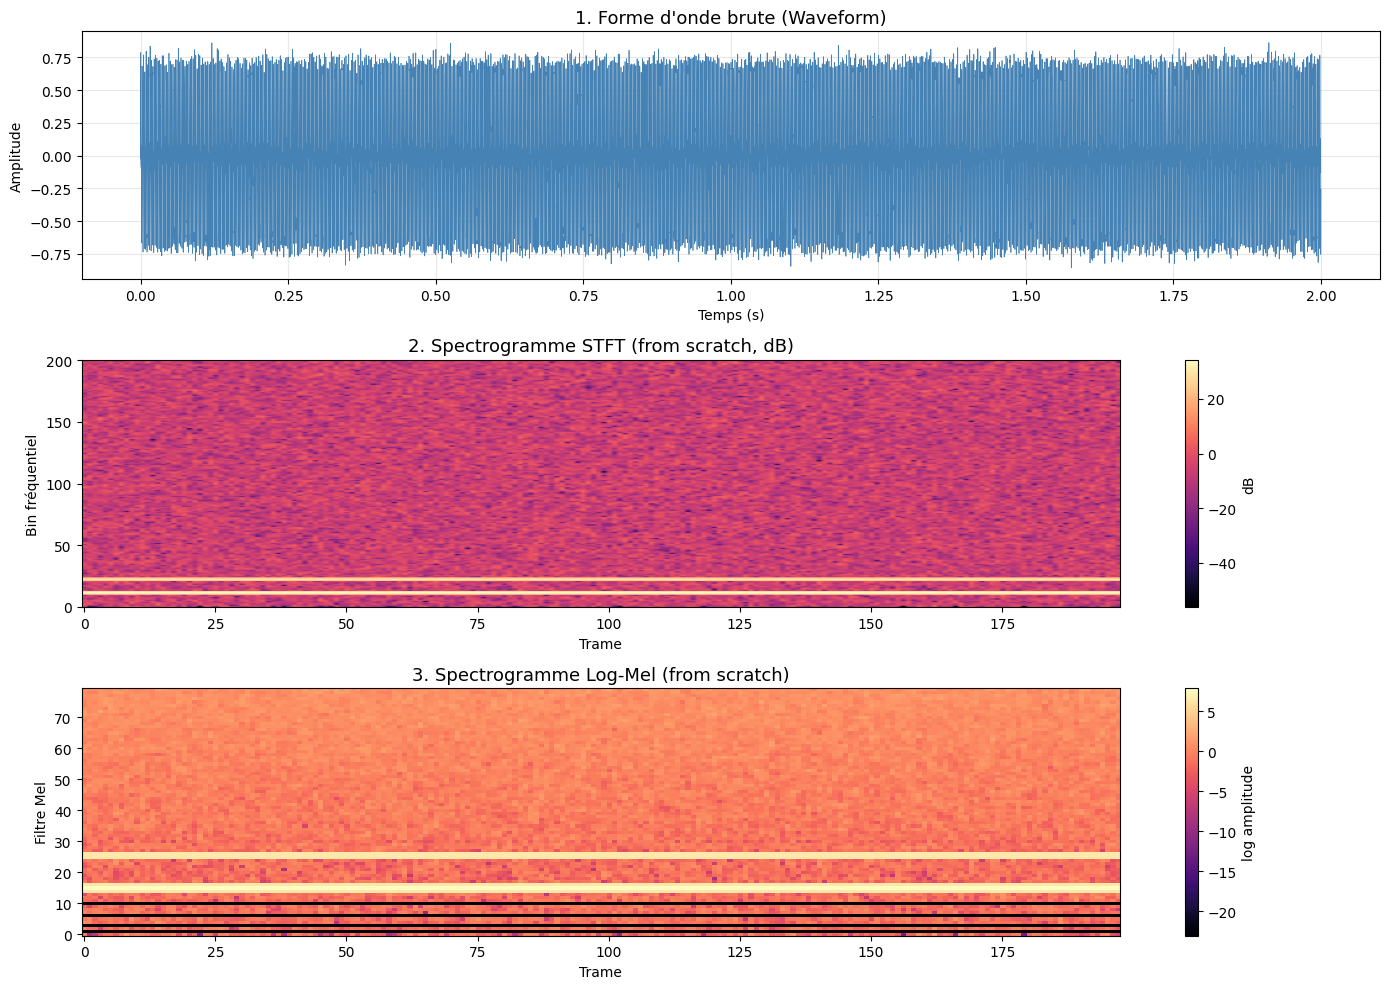

Résumé des dimensions :
  Waveform    : (32000,) — 32000 échantillons à 16000 Hz
  Spectrogramme : (201, 198) — 201 bins × 198 trames
  Log-Mel     : (80, 198) — 80 filtres Mel × 198 trames


In [14]:
fig, axes = plt.subplots(3, 1, figsize=(14, 10))

# 1. Waveform
time_axis = np.arange(len(waveform)) / sr
axes[0].plot(time_axis, waveform, linewidth=0.5, color='steelblue')
axes[0].set_title("1. Forme d'onde brute (Waveform)", fontsize=13)
axes[0].set_xlabel("Temps (s)")
axes[0].set_ylabel("Amplitude")
axes[0].grid(True, alpha=0.3)

# 2. Spectrogramme (from scratch, en dB)
im1 = axes[1].imshow(
    20 * np.log10(np.maximum(1e-10, spectrogram_scratch)),
    aspect='auto', origin='lower', cmap='magma'
)
axes[1].set_title("2. Spectrogramme STFT (from scratch, dB)", fontsize=13)
axes[1].set_xlabel("Trame")
axes[1].set_ylabel("Bin fréquentiel")
fig.colorbar(im1, ax=axes[1], label='dB')

# 3. Log-Mel (from scratch)
im2 = axes[2].imshow(log_mel_scratch, aspect='auto', origin='lower', cmap='magma')
axes[2].set_title("3. Spectrogramme Log-Mel (from scratch)", fontsize=13)
axes[2].set_xlabel("Trame")
axes[2].set_ylabel("Filtre Mel")
fig.colorbar(im2, ax=axes[2], label='log amplitude')

plt.tight_layout()
plt.show()

print("Résumé des dimensions :")
print(f"  Waveform    : {waveform.shape} — {len(waveform)} échantillons à {sr} Hz")
print(f"  Spectrogramme : {spectrogram_scratch.shape} — {spectrogram_scratch.shape[0]} bins × {spectrogram_scratch.shape[1]} trames")
print(f"  Log-Mel     : {log_mel_scratch.shape} — {log_mel_scratch.shape[0]} filtres Mel × {log_mel_scratch.shape[1]} trames")

## Cell 8 — Sérialisation / Désérialisation JSON des features audio

On vérifie que le round-trip `serialize → deserialize` préserve les données.
C'est important pour sauvegarder et recharger des features pré-calculées.

In [15]:
from audio.serialization import serialize_features, deserialize_features

# Construire un dictionnaire de features
features = {
    "waveform": waveform[:1000],  # Sous-ensemble pour la démo
    "sample_rate": sr,
    "spectrogram": spectrogram_scratch[:, :10],  # 10 premières trames
    "log_mel": log_mel_scratch[:, :10],
    "metadata": {
        "duration_seconds": len(waveform) / sr,
        "num_samples": len(waveform),
        "n_mels": n_mels,
        "n_fft": n_fft,
        "hop_length": hop_length,
    },
}

# Sérialiser
json_str = serialize_features(features)
print(f"JSON sérialisé : {len(json_str)} caractères")
print(f"Aperçu (500 premiers caractères) :\n{json_str[:500]}...")

# Désérialiser
restored = deserialize_features(json_str)

# Vérification round-trip
print(f"\n--- Vérification round-trip ---")
for key in ("waveform", "spectrogram", "log_mel"):
    match = np.allclose(features[key], restored[key])
    print(f"  {key:15s} : shape {restored[key].shape}, match = {match}")

print(f"  sample_rate    : {restored['sample_rate']} == {features['sample_rate']} → {restored['sample_rate'] == features['sample_rate']}")
print(f"  metadata       : {restored['metadata'] == features['metadata']}")
print("\n✅ Round-trip réussi !" if all(
    np.allclose(features[k], restored[k]) for k in ("waveform", "spectrogram", "log_mel")
) else "\n❌ Échec du round-trip")

JSON sérialisé : 99865 caractères
Aperçu (500 premiers caractères) :
{
  "waveform": [
    -0.019775390625,
    0.234832763671875,
    0.3800048828125,
    0.519744873046875,
    0.66558837890625,
    0.606842041015625,
    0.7877197265625,
    0.634185791015625,
    0.612762451171875,
    0.521453857421875,
    0.411163330078125,
    0.35723876953125,
    0.174591064453125,
    0.08306884765625,
    0.008514404296875,
    0.0133056640625,
    -0.092498779296875,
    -0.050811767578125,
    0.015167236328125,
    -0.0736083984375,
    -0.022796630859375,
    -0.0...

--- Vérification round-trip ---
  waveform        : shape (1000,), match = True
  spectrogram     : shape (201, 10), match = True
  log_mel         : shape (80, 10), match = True
  sample_rate    : 16000 == 16000 → True
  metadata       : True

✅ Round-trip réussi !
